<a href="https://colab.research.google.com/github/ElinaZ7/AH2179_ElinaZhang/blob/main/Hand_In_Assignment_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Hand In Assignment 3
Elina Zhang AH2179

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
import sklearn.metrics.pairwise as dis_lib
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from google.colab import files

# Load datasets
uploaded = files.upload()
train_data = pd.read_csv("dataset_exercise_5_clustering_highway_traffic.csv", sep=";")
eval_data = pd.read_csv("evaluation_dataset_exercise_5_clustering_highway_traffic.csv", sep=";")

Saving evaluation_dataset_exercise_5_clustering_highway_traffic.csv to evaluation_dataset_exercise_5_clustering_highway_traffic.csv
Saving dataset_exercise_5_clustering_highway_traffic.csv to dataset_exercise_5_clustering_highway_traffic.csv


## Data preparation

In [2]:
# Prepare data by vectorizing day-wise flow values (5-minute intervals)
def vectorize_data(df):
    days = np.unique(df[['Date']].values.ravel())
    n_days = len(days)
    n_intervals = len(df['Interval_5'].unique())
    vectorized_data = np.zeros((n_days, n_intervals))
    vectorized_data.fill(np.nan)

    # Group by Date to aggregate flow data by intervals
    day_subsets = df.groupby(["Date"])
    for i, day in enumerate(days):
        day_data = day_subsets.get_group(day)
        for _, row in day_data.iterrows():
            vectorized_data[i, row["Interval_5"]] = row["flow"]

    return vectorized_data, days

# Prepare training data
vectorized_train_data, days_train = vectorize_data(train_data)

# Remove rows with missing values (NaNs)
nans_per_day_train = np.sum(np.isnan(vectorized_train_data), axis=1)
vectorized_train_data_no_nans = vectorized_train_data[np.where(nans_per_day_train == 0)]
days_train_no_nans = days_train[np.where(nans_per_day_train == 0)]

# Split the data into training and testing sets (80/20 split)
train_set, test_set = train_test_split(vectorized_train_data_no_nans, test_size=0.2, random_state=42)

## Clustering and Parameter calibration

In [3]:
# K-Means clustering
n_clusters_kmeans = 4
kmeans = KMeans(n_clusters=n_clusters_kmeans, random_state=42)
kmeans_labels = kmeans.fit_predict(train_set)

# Compute internal evaluation metrics for K-Means
kmeans_SC = silhouette_score(train_set, kmeans_labels)
kmeans_DB = davies_bouldin_score(train_set, kmeans_labels)
kmeans_CH = calinski_harabasz_score(train_set, kmeans_labels)

print(f'K-Means: Silhouette={kmeans_SC}, Davies-Bouldin={kmeans_DB}, Calinski-Harabasz={kmeans_CH}')

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


K-Means: Silhouette=0.2667923001171188, Davies-Bouldin=1.4075014607776077, Calinski-Harabasz=112.17138134811827


In [4]:
# Agglomerative Clustering
n_clusters_agg = 4
agg = AgglomerativeClustering(n_clusters=n_clusters_agg)
agg_labels = agg.fit_predict(train_set)

# Compute internal evaluation metrics for Agglomerative Clustering
agg_SC = silhouette_score(train_set, agg_labels)
agg_DB = davies_bouldin_score(train_set, agg_labels)
agg_CH = calinski_harabasz_score(train_set, agg_labels)

print(f'Agglomerative: Silhouette={agg_SC}, Davies-Bouldin={agg_DB}, Calinski-Harabasz={agg_CH}')

Agglomerative: Silhouette=0.2521183348249592, Davies-Bouldin=1.3801058711359453, Calinski-Harabasz=109.12736187641906


In [5]:
# DBSCAN Clustering
dbscan = DBSCAN(eps=0.5, min_samples=5)
dbscan_labels = dbscan.fit_predict(train_set)

# Only compute metrics if DBSCAN doesn't assign all points to noise (-1)
if len(np.unique(dbscan_labels)) > 1:
    dbscan_SC = silhouette_score(train_set, dbscan_labels)
    dbscan_DB = davies_bouldin_score(train_set, dbscan_labels)
    dbscan_CH = calinski_harabasz_score(train_set, dbscan_labels)

    print(f'DBSCAN: Silhouette={dbscan_SC}, Davies-Bouldin={dbscan_DB}, Calinski-Harabasz={dbscan_CH}')
else:
    print("DBSCAN: All points classified as noise.")

DBSCAN: All points classified as noise.


## Prediction using Centroid-Based Model

In [6]:
# Function to find the closest centroid for prediction
def find_closest_centroid(centroids, day_data, from_interval, to_interval):
    closest_centroid = None
    min_distance = np.inf
    for i, centroid in enumerate(centroids):
        dist = dis_lib.paired_distances(centroid[:, from_interval:to_interval], day_data[:, from_interval:to_interval], metric='euclidean')
        if dist < min_distance:
            min_distance = dist
            closest_centroid = i
    return closest_centroid

# Build centroids from K-Means clusters
centroids = []
for i in range(n_clusters_kmeans):
    cluster_data = train_set[kmeans_labels == i]
    centroid = np.nanmean(cluster_data, axis=0).reshape(1, -1)
    centroids.append(centroid)

# Prediction and external evaluation
n_past_intervals = 5
total_mae, total_mape, prediction_count = 0, 0, 0

for day in test_set:
    for j in range(n_past_intervals, day.shape[0] - 1):
        centroid_idx = find_closest_centroid(centroids, day.reshape(1, -1), j - n_past_intervals, j)
        predicted_value = centroids[centroid_idx][0, j + 1]

        actual_value = day[j + 1]
        mae = abs(predicted_value - actual_value)
        mape = mae / actual_value if actual_value != 0 else 0

        total_mae += mae
        total_mape += mape
        prediction_count += 1

# Calculate MAE and MAPE for prediction accuracy
print('Prediction MAE:', total_mae / prediction_count)
print('Prediction MAPE:', total_mape / prediction_count)


Prediction MAE: 24.818958257566912
Prediction MAPE: 0.43218098192401017


## Visualization

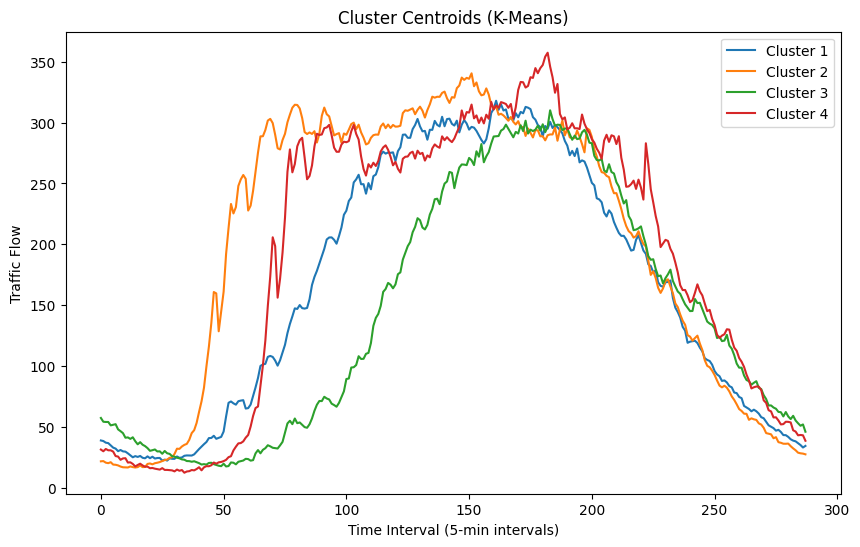

In [7]:
# Plot the centroids of the clusters identified by K-Means
def plot_centroids(centroids, n_intervals):
    plt.figure(figsize=(10, 6))
    for i, centroid in enumerate(centroids):
        plt.plot(centroid.flatten(), label=f'Cluster {i+1}')

    plt.title('Cluster Centroids (K-Means)')
    plt.xlabel('Time Interval (5-min intervals)')
    plt.ylabel('Traffic Flow')
    plt.legend()
    plt.show()

# Plot K-Means centroids
plot_centroids(centroids, n_intervals=train_set.shape[1])

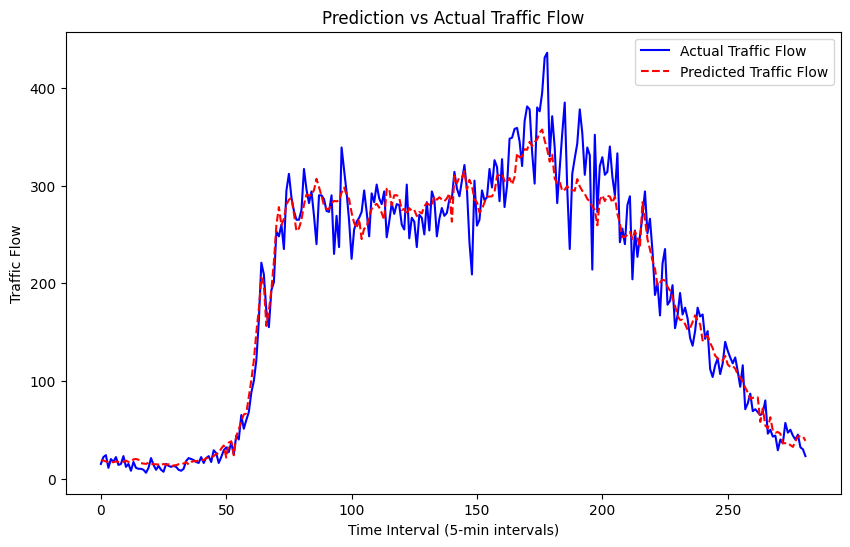

In [9]:
# Plot predicted vs actual traffic flow for a sample day
def plot_prediction_vs_actual(centroids, day_data, n_past_intervals, day_index):
    plt.figure(figsize=(10, 6))

    actual = day_data[day_index]
    predicted = []

    for j in range(n_past_intervals, actual.shape[0] - 1):
        centroid_idx = find_closest_centroid(centroids, actual.reshape(1, -1), j - n_past_intervals, j)
        predicted_value = centroids[centroid_idx][0, j + 1]
        predicted.append(predicted_value)

    # Plot actual and predicted values
    plt.plot(actual[n_past_intervals+1:], label='Actual Traffic Flow', color='blue')
    plt.plot(predicted, label='Predicted Traffic Flow', color='red', linestyle='dashed')

    plt.title('Prediction vs Actual Traffic Flow')
    plt.xlabel('Time Interval (5-min intervals)')
    plt.ylabel('Traffic Flow')
    plt.legend()
    plt.show()

# Plot for a sample day (e.g., first day in the test set)
plot_prediction_vs_actual(centroids, test_set, n_past_intervals=5, day_index=0)